## Import all the necessary library

In [13]:
!pip install seaborn

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib


In [3]:
data = pd.read_csv('training-data.csv')

In [4]:
test_data = pd.read_csv("predict-data.csv")

C:\Users\hp\AppData\Local\Temp\ipykernel_12028\2298241144.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("predict-data.csv")


# Cleaning Code

Filter the dataframe to only show rows with column value type is 'HHI'

In [5]:
data_hhi = data[data['Type'] == 'HHI']

In [6]:
data_hhi.columns

Index(['AudienceID', 'LotameID', 'y', 'Name', 'Type', 'fullVisitorId',
       'browser', 'operatingSystem', 'operatingSystemVersion', 'isMobile',
       'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector',
       'mobileDeviceInfo', 'mobileDeviceMarketingName', 'screenResolution',
       'language', 'continent', 'subContinent', 'country', 'region', 'city',
       'sec', 'sub_sec', 'pageTitle', 'url', 'onPageTime', 'nextTime',
       'user_active_days', 'total_visit_counts', 'total_unique_session',
       'total_time_spent', 'time_spent_per_session', 'timeOnPage',
       'GAClientId', 'cookie_id'],
      dtype='object')

In [7]:
data_hhi['y'].count

<bound method Series.count of 603           1500-
604           1500-
605           1500-
1844     1.500-5000
1845     1.500-5000
            ...    
89895         5000+
89896         5000+
89897         5000+
89898         5000+
89899         5000+
Name: y, Length: 2361, dtype: object>

Check which column has null values

In [8]:
#Check column with null value
null_counts = data_hhi.isnull().sum()

# Display the null counts
null_counts

AudienceID                      0
LotameID                        0
y                               0
Name                            0
Type                            0
fullVisitorId                   0
browser                         0
operatingSystem                 0
operatingSystemVersion          0
isMobile                        0
mobileDeviceBranding          136
mobileDeviceModel             136
mobileInputSelector           136
mobileDeviceInfo                0
mobileDeviceMarketingName     136
screenResolution                0
language                        0
continent                       0
subContinent                    0
country                         0
region                          0
city                            0
sec                             0
sub_sec                      1036
pageTitle                       1
url                             0
onPageTime                      0
nextTime                        0
user_active_days                0
total_visit_co

- Replacing null values in 'pageTitle' by taking the value from another column 'sec' which will be then transform by removing the symbols and substitude it with whitespace

- Replacing null values with (not set) for this three column :
1. mobileDeviceBranding
2. mobileDeviceModel
3. mobileInputSelector
4. mobileDeviceMarketingName

This is because when column 'isMobile' is FALSE these 4 column will be empty which means the user is using 'non mobile' device (ie. laptop)


- Replacing null value in 'sub_sec' by filling it with none

In [9]:
# Define a function to preprocess the 'sec' column
def preprocess_sec(sec_value):
    # Remove symbols from the 'sec' value and replace them with whitespace
    sec_value = ''.join(char if char.isalnum() else ' ' for char in sec_value)
    return sec_value.strip()

# # Apply the preprocessing function to the 'sec' column and fill null values in the 'target_column'
data_hhi['pageTitle'] = data_hhi.apply(lambda row: row['sec'] if pd.isnull(row['pageTitle']) else row['pageTitle'], axis=1)

# Preprocess the 'sec' column using the defined function
data_hhi['pageTitle'] = data_hhi['pageTitle'].apply(preprocess_sec)

# Replace null values in the specified column with 'replacement_value'
replacement_value = '(not set)'
data_hhi['mobileDeviceBranding'] = data_hhi['mobileDeviceBranding'].fillna(replacement_value)
data_hhi['mobileDeviceModel'] = data_hhi['mobileDeviceModel'].fillna(replacement_value)
data_hhi['mobileInputSelector'] = data_hhi['mobileInputSelector'].fillna(replacement_value)
data_hhi['mobileDeviceMarketingName'] = data_hhi['mobileDeviceMarketingName'].fillna(replacement_value)


data_hhi['sub_sec'] = data_hhi['sub_sec'].fillna('none')


C:\Users\hp\AppData\Local\Temp\ipykernel_12028\1953185174.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hhi['pageTitle'] = data_hhi.apply(lambda row: row['sec'] if pd.isnull(row['pageTitle']) else row['pageTitle'], axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_12028\1953185174.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hhi['pageTitle'] = data_hhi['pageTitle'].apply(preprocess_sec)
C:\Users\hp\AppData\Local\Temp\ipykernel_12028\1953185174.py:15: SettingWithCopyWarning: 
A value i

Perform Label Encoding for the feature that will be used for the model (training data and predict data)

In [10]:
training_data = data_hhi.loc[:, ['y', 'onPageTime', 'nextTime', 'user_active_days', 'total_visit_counts'
                                    ,'total_unique_session', 'total_time_spent', 'time_spent_per_session', 
                                    'timeOnPage', 'continent', 'subContinent', 'country']]



predict_data = test_data.loc[:, ['onPageTime', 'nextTime', 'user_active_days', 'total_visit_counts'
                                    ,'total_unique_session', 'total_time_spent', 'time_spent_per_session', 
                                    'timeOnPage', 'continent', 'subContinent', 'country']]


In [11]:
label_encoder_cont = LabelEncoder()

# Combine the unique colors from both data frames
cont_unique = pd.concat([training_data["continent"], predict_data["continent"]]).unique()
cont_enc_fit = label_encoder_cont.fit(cont_unique)

training_data["Continent_Encoded"] = label_encoder_cont.transform(training_data['continent'])
predict_data["Continent_Encoded"] = label_encoder_cont.transform(predict_data['continent'])

cont_enc_fit.classes_


array(['(not set)', 'Africa', 'Americas', 'Asia', 'Europe', 'Oceania'],
      dtype=object)

In [12]:
label_encoder_sub_cont = LabelEncoder()

# Combine the unique colors from both data frames
sub_cont_unique = pd.concat([training_data["subContinent"], predict_data["subContinent"]]).unique()
sub_cont_enc_fit = label_encoder_sub_cont.fit(sub_cont_unique)

training_data["SubContinent_Encoded"] = label_encoder_sub_cont.transform(training_data['subContinent'])
predict_data["SubContinent_Encoded"] = label_encoder_sub_cont.transform(predict_data['subContinent'])

sub_cont_enc_fit.classes_


array(['(not set)', 'Australasia', 'Caribbean', 'Central America',
       'Central Asia', 'Eastern Africa', 'Eastern Asia', 'Eastern Europe',
       'Melanesia', 'Micronesian Region', 'Middle Africa',
       'Northern Africa', 'Northern America', 'Northern Europe',
       'Polynesia', 'South America', 'Southeast Asia', 'Southern Africa',
       'Southern Asia', 'Southern Europe', 'Western Africa',
       'Western Asia', 'Western Europe'], dtype=object)

In [13]:
label_encoder_country = LabelEncoder()

# Combine the unique colors from both data frames
country_unique = pd.concat([training_data["country"], predict_data["country"]]).unique()
country_enc_fit = label_encoder_country.fit(country_unique)

training_data["Country_Encoded"] = label_encoder_country.transform(training_data['country'])
predict_data["Country_Encoded"] = label_encoder_country.transform(predict_data['country'])

country_enc_fit.classes_


array(['(not set)', 'Algeria', 'Andorra', 'Argentina', 'Australia',
       'Austria', 'Bahrain', 'Bangladesh', 'Belgium', 'Bhutan',
       'Bosnia & Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Cambodia',
       'Canada', 'China', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
       'Egypt', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'French Polynesia', 'Gabon', 'Germany', 'Greece', 'Guam',
       'Hong Kong', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq',
       'Ireland', 'Italy', 'Japan', 'Kazakhstan', 'Kenya', 'Kosovo',
       'Laos', 'Libya', 'Luxembourg', 'Macao', 'Malaysia', 'Maldives',
       'Mauritania', 'Mauritius', 'Mexico', 'Montenegro',
       'Myanmar (Burma)', 'Nepal', 'Netherlands', 'New Caledonia',
       'New Zealand', 'Nigeria', 'North Macedonia', 'Norway', 'Oman',
       'Pakistan', 'Papua New Guinea', 'Philippines', 'Poland',
       'Portugal', 'Qatar', 'Romania', 'Russia', 'Saudi Arabia', 'Serbia',
       'Seyche

In [14]:
label_encoder_income = LabelEncoder()

# Combine the unique colors from both data frames
income = training_data['y']
conun_enc_fit = label_encoder_income.fit(income)

training_data["Income_Encoded"] = label_encoder_income.transform(training_data['y'])


conun_enc_fit.classes_


array(['1.500-5000', '1500-', '5000+'], dtype=object)

In [15]:
training_df = training_data.copy()
predicting_df = predict_data.copy()

In [16]:
training_df.drop("continent", axis=1, inplace=True)
training_df.drop("subContinent", axis=1, inplace=True)
training_df.drop("country", axis=1, inplace=True)
training_df.drop("y", axis=1, inplace=True)

predicting_df.drop("continent", axis=1, inplace=True)
predicting_df.drop("subContinent", axis=1, inplace=True)
predicting_df.drop("country", axis=1, inplace=True)

This one to handle the null value in the predict dataset

In [17]:
mean_value_session = predicting_df['time_spent_per_session'].mean()
predicting_df['time_spent_per_session'].fillna(mean_value_session, inplace=True)

mean_value_spent = predicting_df['total_time_spent'].mean()
predicting_df['total_time_spent'].fillna(mean_value_spent, inplace=True)


# EDA on Training Dataset

In [18]:
training_df.head()

,onPageTime,nextTime,user_active_days,total_visit_counts,total_unique_session,total_time_spent,time_spent_per_session,timeOnPage,Continent_Encoded,SubContinent_Encoded,Country_Encoded,Income_Encoded
603,0,91472,5,43,5,735.0,154.0,91472,3,16,49,1
604,91472,103015,5,43,5,735.0,154.0,11543,3,16,49,1
605,103015,143773,5,43,5,735.0,154.0,40758,3,16,49,1
1844,0,126729,5,237,8,1385.0,217.0,126729,3,16,49,0
1845,126729,207157,5,237,8,1385.0,217.0,80428,3,16,49,0


In [19]:
training_df.columns

Index(['onPageTime', 'nextTime', 'user_active_days', 'total_visit_counts',
       'total_unique_session', 'total_time_spent', 'time_spent_per_session',
       'timeOnPage', 'Continent_Encoded', 'SubContinent_Encoded',
       'Country_Encoded', 'Income_Encoded'],
      dtype='object')

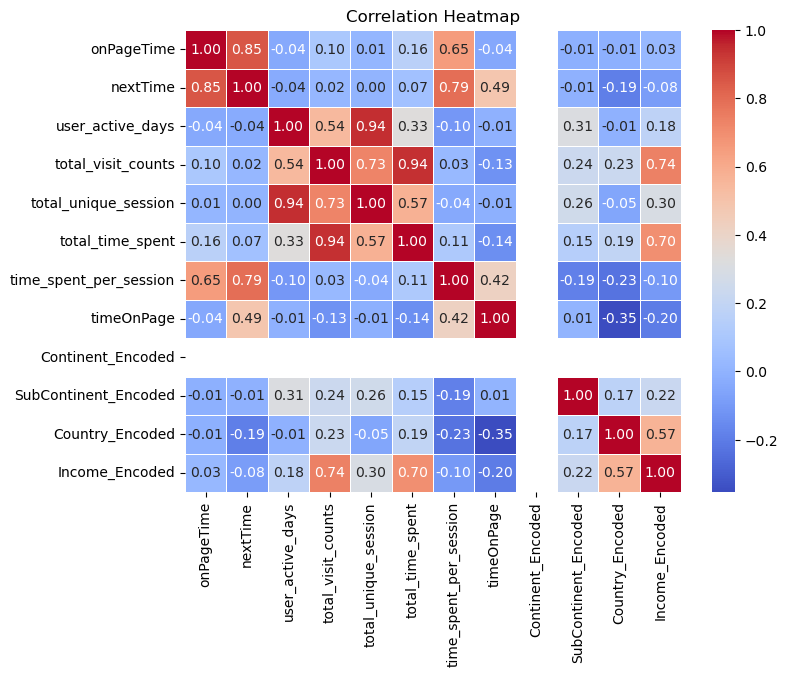

In [20]:
correlation_matrix = training_df.corr()

# Create the correlation heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

The code below can be ignore since I just want to test if the encoded value can be reverse back

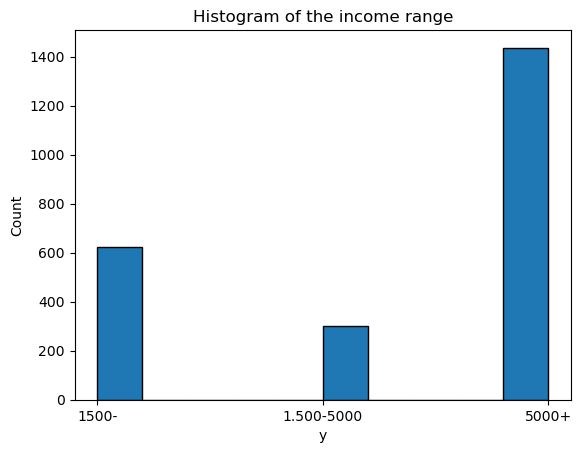

In [21]:
# # Plot histogram for 'column1'
plt.hist(data_hhi['y'], bins=10, edgecolor='black')
plt.xlabel('y')
plt.ylabel('Count')
plt.title('Histogram of the income range')
plt.show()

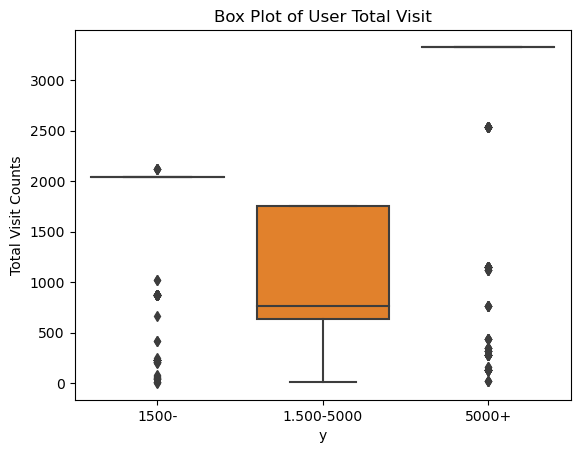

In [22]:
sns.boxplot(x='y', y='total_visit_counts', data=data_hhi)
plt.ylabel('Total Visit Counts')
plt.title('Box Plot of User Total Visit')
plt.show()

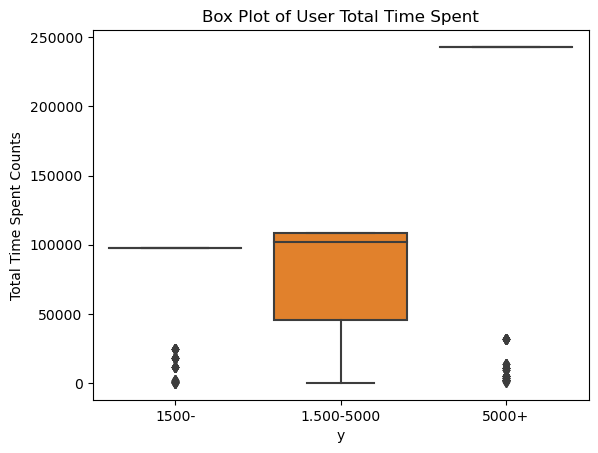

In [24]:
sns.boxplot(x='y', y='total_time_spent', data=data_hhi)
plt.ylabel('Total Time Spent Counts')
plt.title('Box Plot of User Total Time Spent')
plt.show()

# Decision Tree Model (Training Dataset)



In [159]:
# Split the dataset into features (X) and the encoded income bins (y_encoded)
X = training_df.drop(['Income_Encoded'], axis=1)
y_encoded = training_df['Income_Encoded']

# Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.8, random_state=42, stratify=y_encoded)

# Initialize the Decision Tree classifier
decision_tree = DecisionTreeClassifier()

# Train the model
decision_tree.fit(X_train, y_train_encoded)

# Make predictions on the test set
y_pred_encoded = decision_tree.predict(X_test)



# Evaluate the model's accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print("Accuracy:", accuracy)

# Print a classification report for more detailed metrics
classification_rep = classification_report(y_test_encoded, y_pred_encoded)
print("Classification Report:\n", classification_rep)
print("Train and test amount: ", len(X_train), len(X_test))

Accuracy: 0.9777660137638963
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       242
           1       0.98      0.97      0.98       498
           2       0.99      0.98      0.99      1149

    accuracy                           0.98      1889
   macro avg       0.96      0.97      0.97      1889
weighted avg       0.98      0.98      0.98      1889

Train and test amount:  472 1889


In [161]:
y_pred_original = label_encoder_income.inverse_transform(y_encoded)

# Compare the predicted income bins with the original income bins
y_test_original = training_df.loc[y_test_encoded.index, 'Income_Encoded']

# Create a new column to store predicted income bins alongside original income bins
training_data['predicted_income'] = label_encoder_income.inverse_transform(y_encoded)

In [35]:
training_data.head()

,y,onPageTime,nextTime,user_active_days,total_visit_counts,total_unique_session,total_time_spent,time_spent_per_session,timeOnPage,continent,subContinent,country,Continent_Encoded,SubContinent_Encoded,Country_Encoded,Income_Encoded
603,1500-,0,91472,5,43,5,735.0,154.0,91472,Asia,Southeast Asia,Malaysia,3,16,49,1
604,1500-,91472,103015,5,43,5,735.0,154.0,11543,Asia,Southeast Asia,Malaysia,3,16,49,1
605,1500-,103015,143773,5,43,5,735.0,154.0,40758,Asia,Southeast Asia,Malaysia,3,16,49,1
1844,1.500-5000,0,126729,5,237,8,1385.0,217.0,126729,Asia,Southeast Asia,Malaysia,3,16,49,0
1845,1.500-5000,126729,207157,5,237,8,1385.0,217.0,80428,Asia,Southeast Asia,Malaysia,3,16,49,0


In [37]:
selected_columns = training_data[['y', 'predicted_income']]


In [164]:
# Replace 'model_path.pkl' with the desired path to save the trained model
joblib.dump(decision_tree, 'model_path.pkl')

# Step 4: Load the trained model from the file
# Replace 'model_path.pkl' with the path where you saved the trained model
loaded_model = joblib.load('model_path.pkl')

# Make predictions on the new dataset using the loaded model
new_predictions = loaded_model.predict(predicting_df)

# add the predictions as a new column to the new dataset
# Replace 'predicted_target' with the desired column name for the predictions
predicting_df['predicted_target'] = new_predictions


In [165]:
test_data['Predict_Income'] = label_encoder_income.inverse_transform(predicting_df['predicted_target'])

In [38]:
test_data.head()

,fullVisitorId,browser,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,...,nextTime,user_active_days,total_visit_counts,total_unique_session,total_time_spent,time_spent_per_session,timeOnPage,GAClientId,LotamePId,cookie_id
0,7.210581e+18,Chrome,Windows,10,False,NaN,NaN,NaN,(not set),NaN,...,622603,26,288,28,64249.0,745.0,28544,1678844266.1601130913,cfc2191ee705fd7e67b8fb534d9bc328,DJQ2zQvZSCmo_rMc
1,7.210581e+18,Chrome,Windows,10,False,NaN,NaN,NaN,(not set),NaN,...,736919,26,288,28,64249.0,854.0,228622,1678844266.1601130913,cfc2191ee705fd7e67b8fb534d9bc328,DJQ2zQvZSCmo_rMc
2,7.210581e+18,Chrome,Windows,10,False,NaN,NaN,NaN,(not set),NaN,...,567794,26,288,28,64249.0,626.0,40437,1678844266.1601130913,cfc2191ee705fd7e67b8fb534d9bc328,DJQ2zQvZSCmo_rMc
3,7.210581e+18,Chrome,Windows,10,False,NaN,NaN,NaN,(not set),NaN,...,66022,26,288,28,64249.0,1111.0,65774,1678844266.1601130913,cfc2191ee705fd7e67b8fb534d9bc328,DJQ2zQvZSCmo_rMc
4,7.210581e+18,Chrome,Windows,10,False,NaN,NaN,NaN,(not set),NaN,...,48409,26,288,28,64249.0,222.0,47252,1678844266.1601130913,cfc2191ee705fd7e67b8fb534d9bc328,DJQ2zQvZSCmo_rMc


In [168]:
test_data.to_csv('prediction_data_output.csv', index=False)